In [1]:
import pandas as pd

import collections

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

In [3]:
# number of proteins
len(G.nodes())

10215

In [4]:
# number of interactions
G.number_of_edges()

42351

In [5]:
# degree histogram
degrees = sorted([d for n, d in G.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

Text(0, 0.5, 'number of nodes')

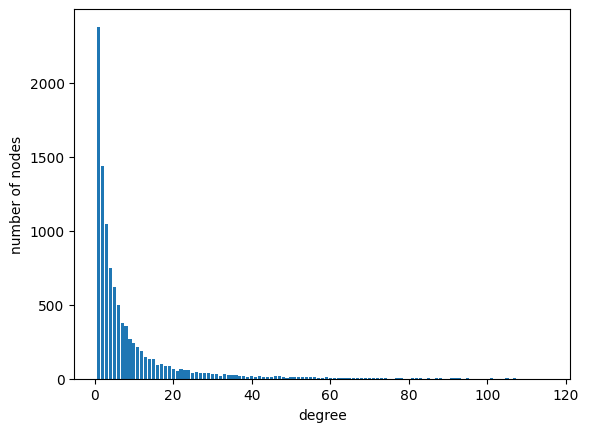

In [6]:
plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

### Count candidate genes for each node

In [7]:
candidates = pd.read_pickle("./data/candidateGenesList.p")

In [8]:
d = {}

In [9]:
# count candidate genes for each node
for node in G.nodes():
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G.nodes()] if x in candidates]
    candidates_in_neighbourhood_cnt = len(candidates_in_neighbourhood)
    d[node] = candidates_in_neighbourhood_cnt

In [22]:
s = pd.Series(d, name='# candidates in neighbourhood')
s.index.name = 'Gene'
s.reset_index()
s.sort_values(ascending=False)

Gene
ENSG00000101773    5
ENSG00000121989    4
ENSG00000174371    4
ENSG00000175054    4
ENSG00000164053    4
                  ..
ENSG00000142677    0
ENSG00000163599    0
ENSG00000198851    0
ENSG00000135636    0
ENSG00000137767    0
Name: # candidates in neighbourhood, Length: 10215, dtype: int64

Text(0, 0.5, 'number of nodes')

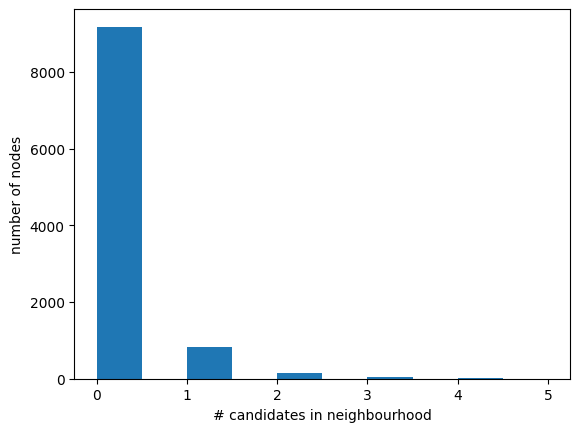

In [26]:
ax = s.plot.hist()
ax.set_xlabel("# candidates in neighbourhood")
ax.set_ylabel("number of nodes")